### Load Dataset

In [1]:
import pandas as pd
import numpy as np

clients = pd.read_csv('../data/processed/clients.csv')
orders = pd.read_csv('../data/processed/orders.csv')
orders_raw = pd.read_csv('../data/processed/orders_raw.csv')

In [3]:
clients[clients['client_id'] == 365042657][['client_id','median_promotor_visits']]

,client_id,median_promotor_visits
12405,365042657,20.0


#### Insight 1: Most clients have inneficienties in their contacts or visits for high and low median ticket values

In [5]:
# Check balance: include both count and percentage columns
balance_counts = clients['Class'].value_counts().rename_axis('Class').reset_index(name='count')
balance_percent = clients['Class'].value_counts(normalize=True).rename_axis('Class').reset_index(name='percentage')
balance = pd.merge(balance_counts, balance_percent, on='Class')
(balance)

,Class,count,percentage
0,HighTicket_Inefficient,16663,0.397211
1,LowTicket_Inefficient,13698,0.326532
2,HighTicket_Efficient,6750,0.160906
3,LowTicket_Efficient,4839,0.115352


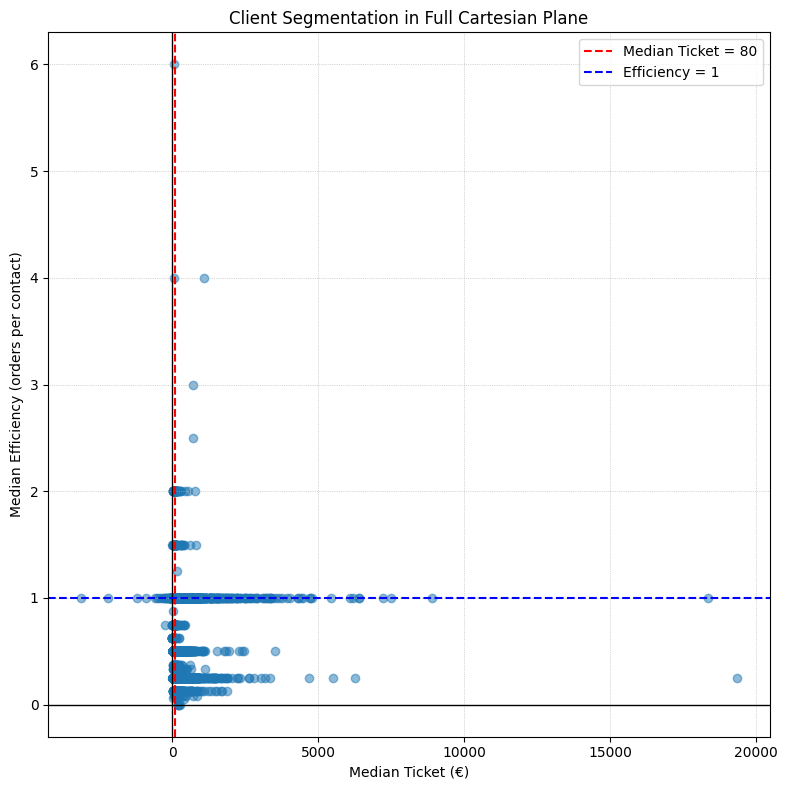

In [14]:
import matplotlib.pyplot as plt

x = clients['median_ticket_year']
y = clients['median_efficiency_orders']

plt.figure(figsize=(8,8))

# scatter all points (you can color by quadrant as before)
plt.scatter(x, y, alpha=0.5)

# draw the main axes at zero
plt.axvline(0, color='black', linewidth=1)
plt.axhline(0, color='black', linewidth=1)

# draw your business thresholds
plt.axvline(80, color='red', linestyle='--', label='Median Ticket = 80')
plt.axhline(1,  color='blue', linestyle='--', label='Efficiency = 1')

plt.xlabel('Median Ticket (€)')
plt.ylabel('Median Efficiency (orders per contact)')
plt.title('Client Segmentation in Full Cartesian Plane')
plt.legend(loc='upper right')
plt.grid(True, which='both', linestyle=':', linewidth=0.5)

plt.tight_layout()
plt.show()

#### High-Ticket & Inefficient clients

In [15]:
# Filter High-Value & Inefficient clients
hv_ineff = clients[clients['quadrant'] == 'HighTicket_Inefficient'].copy()

# Build the reporting table
df_hv_ineff = hv_ineff.reset_index()[[
    'client_id',
    'median_ticket_year',
    'total_orders',
    'total_promotor_visits',
    'avg_orders_per_month',
    'avg_visits_per_month',
    'visit_order_gap',
    'inefficiency_cost',
    'total_profit',
    'profit_per_visit',
    'opportunity_cost'
]].sort_values('opportunity_cost', ascending=False)

# Display first 10 rows
df_hv_ineff.head(10)

KeyError: "['total_promotor_visits'] not in index"

In [32]:
worst_client =int(df_hv_ineff.iloc[0].client_id)
print(f'Client with most opportunity cost: {worst_client}')

# 1) Filter the raw df for that client
df_client = orders[orders['client_id'] == 	215933226]
n_days = len(df_client)
total_orders = df_client['number_of_orders'].sum()

print(f"Client {worst_client} appears on {n_days} days and placed {total_orders} orders in total.")

# 2) Sum only that client’s orders:
visits = df_client['promotor_visits'].sum()
print(f"Client {worst_client} has {visits} visits in total.")


Client with most opportunity cost: 215933226
Client 215933226 appears on 81 days and placed 101 orders in total.
Client 215933226 has 324 visits in total.


In [33]:
inefficiency_cost= df_hv_ineff['inefficiency_cost'].sum().round()
print(f'The cost due to inefficiencies is ${inefficiency_cost:,}')

total_profit = (
    df_hv_ineff['profit_per_visit'] 
  * df_hv_ineff['total_orders']
).sum().round()

print(f'The total profit is €{total_profit:,}')

cost_of_opportunity = df_hv_ineff['opportunity_cost'].sum().round()
print(f'The cost of opportunity is ${cost_of_opportunity:,}')


The cost due to inefficiencies is $1,144,228.0
The total profit is €41,337,977.0
The cost of opportunity is $3,403,286.0


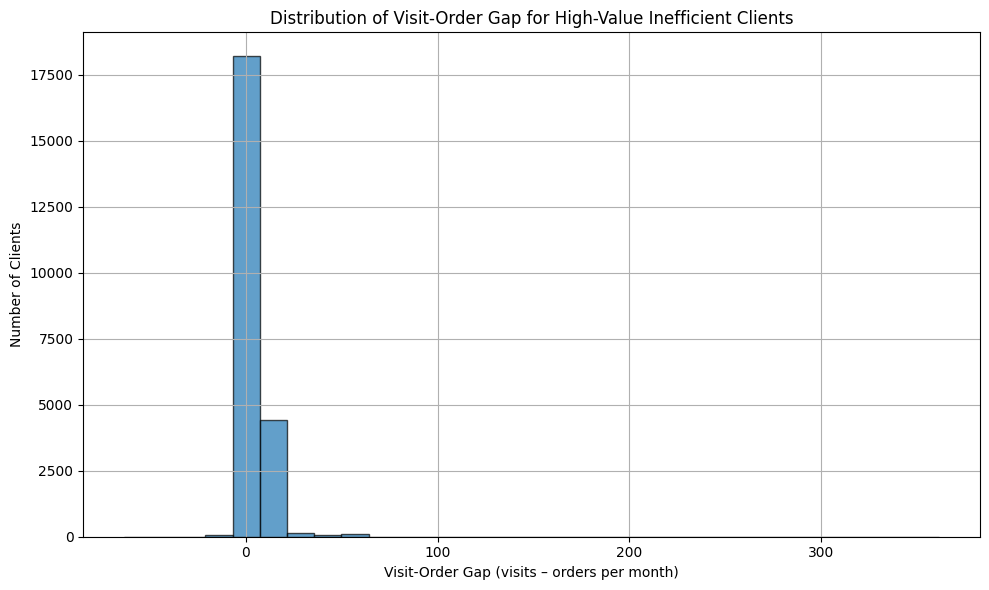

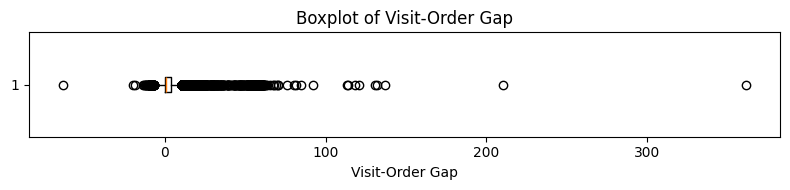

In [37]:
# Extract the gap
gap = hv_ineff['visit_order_gap'].dropna()

#  Histogram
plt.figure(figsize=(10, 6))
plt.hist(gap, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Visit-Order Gap (visits – orders per month)')
plt.ylabel('Number of Clients')
plt.title('Distribution of Visit-Order Gap for High-Value Inefficient Clients')
plt.grid(True)
plt.tight_layout()
plt.show()

#  Boxplot
plt.figure(figsize=(8, 2))
plt.boxplot(gap, vert=False)
plt.xlabel('Visit-Order Gap')
plt.title('Boxplot of Visit-Order Gap')
plt.tight_layout()
plt.show()

# Distribution inisghts

 ### 1) Most reps only “over-visit” by a little:

In the histogram, the huge bar around the 0–25 range means the vast majority of clients see no more than about 25 extra visits each month most are only modestly over visited.

### 2) A tiny tail of extreme cases:

There are bars that  past 100, 200, even 300 extra visits. Those are a few accounts where reps are going hundreds of times more than the orders they get.

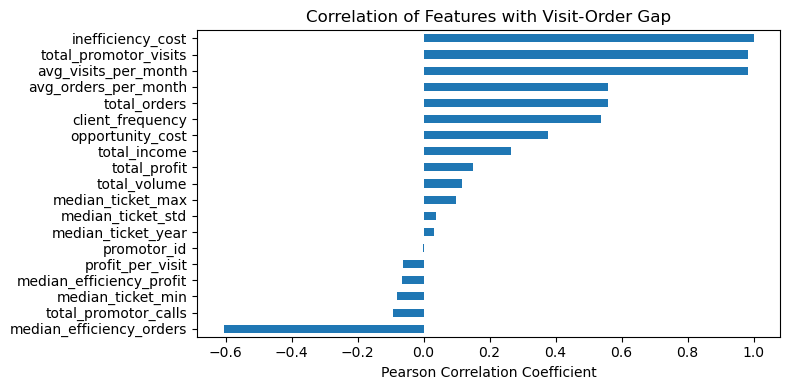

In [217]:
import numpy as np
numeric = hv_ineff.select_dtypes(include=[np.number])
visit_corr = numeric.corr()['visit_order_gap'].drop('visit_order_gap').sort_values()

# 3) Plot bar chart
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
visit_corr.plot(kind='barh')
plt.title('Correlation of Features with Visit-Order Gap')
plt.xlabel('Pearson Correlation Coefficient')
plt.tight_layout()
plt.show()

The correlation shows that the number of order is a important variable to undrstand the gap 

Insight: The gap is driven almost entirely by sheer visit volume rather than ticket size or calls clients who get tons of visits naturally show large gaps, especially if their day to day efficiency is low.

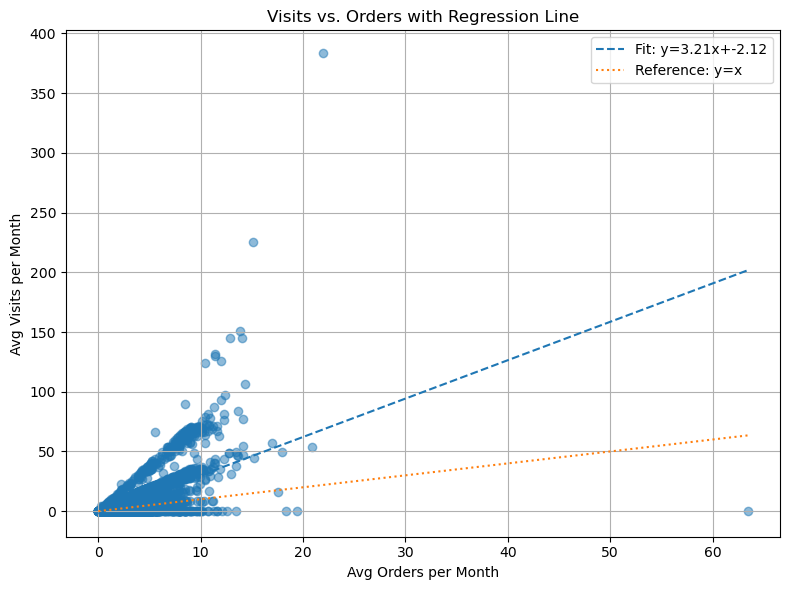

In [ ]:
# Prepare data
x = hv_ineff['avg_orders_per_month']
y = hv_ineff['avg_visits_per_month']

#  Fit a linear regression line
slope, intercept = np.polyfit(x, y, deg=1)

# Line endpoints
x_line = np.array([x.min(), x.max()])
y_line = slope * x_line + intercept


plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5)
plt.plot(x_line, y_line, linestyle='--', label=f'Fit: y={slope:.2f}x+{intercept:.2f}')
plt.plot(x_line, x_line, linestyle=':', label='Reference: y=x')

plt.xlabel('Avg Orders per Month')
plt.ylabel('Avg Visits per Month')
plt.title('Visits vs. Orders with Regression Line')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [221]:
# drop extreme order‐volume outliers
mask = hv_ineff['avg_orders_per_month'] <= 30
hv_typical = hv_ineff[mask]

# fit again
slope_t, intercept_t = np.polyfit(
    hv_typical['avg_orders_per_month'],
    hv_typical['avg_visits_per_month'],
    deg=1
)
print(f"Refit slope (orders≤30): {slope_t:.2f}")


Refit slope (orders≤30): 3.36


In [ ]:


# Buckets
hv_ineff['order_bin'] = pd.cut(
    hv_ineff['avg_orders_per_month'],
    bins=[0, 5, 15, 30, np.inf],
    labels=['Low','Mid','High','Ultra']
)

# Counts per bin
print("Counts per bin:")
print(hv_ineff['order_bin'].value_counts(), "\n")

# Fit and collect slopes
results = {}
for bin_label, group in hv_ineff.groupby('order_bin', observed=True):
    # show the number of clients in this bin
    n_clients = len(group)
    X = sm.add_constant(group['avg_orders_per_month'])
    y = group['avg_visits_per_month']
    model = sm.OLS(y, X).fit()
    results[bin_label] = (n_clients, model.params['avg_orders_per_month'])

for label, (count, slope) in results.items():
    print(f"{label:>5} bin: {count} clients, slope = {slope:.2f}")


Counts per bin:
order_bin
Low      21654
Mid       1298
High         9
Ultra        1
Name: count, dtype: int64 

  Low bin: 21654 clients, slope = 2.68
  Mid bin: 1298 clients, slope = 6.22
 High bin: 9 clients, slope = 15.76
Ultra bin: 1 clients, slope = 0.00


In [ ]:
# Broader bins: Low (0–5), MidHigh (6–30), Ultra (>30)
hv_ineff['order_seg'] = pd.cut(
    hv_ineff['avg_orders_per_month'],
    bins=[0,5,30,np.inf],
    labels=['Low','MidHigh','Ultra']
)

print("Counts per segment:\n", hv_ineff['order_seg'].value_counts(), "\n")

slopes = {}
for seg, grp in hv_ineff.groupby('order_seg', observed=True):
    X = sm.add_constant(grp['avg_orders_per_month'])
    y = grp['avg_visits_per_month']
    model = sm.OLS(y, X).fit()
    slopes[seg] = model.params['avg_orders_per_month']


for seg, slope in slopes.items():
    print(f"{seg:>8} segment slope: {slope:.2f}")

Counts per segment:
 order_seg
Low        21654
MidHigh     1307
Ultra          1
Name: count, dtype: int64 

     Low segment slope: 2.68
 MidHigh segment slope: 6.26
   Ultra segment slope: 0.00


# High Value Low Effiency insights

### 1) Overall over-visiting:

On average promootrs make 3.36 visits for every order they place (ideal is 1 visit/order).

### 2) Most clients are “Low-volume”:

21 654 clients (94.3 %) place ≤ 5 orders/month.

Those get 2.68 visits per order on average—still over-visiting, but less extremely.

### 3) A smaller “Mid-volume” group is worst:

1 307 clients (5.7 %) place 6–15 orders/month.

Those get 6.22 visits per order—that’s over six visits for each order, the biggest inefficiency.

### 4) Tiny “High” & “Ultra” bins are unreliable:

Only 25 clients (0.1 %) place 16–30 orders/month, and 1 client > 30.

Their fitted slopes (15.8 and 0.0) aren’t meaningful because the groups are so small.

